In [1]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pickle
from pathlib import Path
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from datetime import datetime, timedelta
from scipy.stats import gmean

from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from matplotlib.colors import LinearSegmentedColormap


import geopandas as gpd
from mpl_toolkits.basemap import Basemap as Basemap
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.dates as mdates
def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)

In [3]:
def pull_flusight_predictions(model,date):
    """pull_flusight_predictions. Load predictions of the model saved by the scenario modeling
    hub.

    Parameters
    ----------
    model : str
        Model name on the
    dates : list or string
        List of potential dates in the iso format, e.g., 'yyyy-mm-dd', for the submission.
    """
    predictions = None
    
    url = f"https://raw.githubusercontent.com/cdcepi/Flusight-forecast-hub/main/model-output/{model}/{date}-{model}"
    for ext in [".csv",".gz",".zip",".csv.zip",".csv.gz", '.parquet']:
        try:
            if ext == '.parquet':
                predictions = pd.read_parquet(url+ext,engine='auto')
                predictions['location'] = predictions['location'].astype(str)
                predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
            else:
                predictions = pd.read_csv(url+ext,dtype={'location':str},parse_dates=['target_end_date'])
        except:
            pass
    if predictions is None:
        print(f"Data for model {model} and date {date} unavailable")
    return predictions


def pull_surveillance_data():
    mapping = {'death':'Deaths', 'case':'Cases', 'hospitalization': 'Hospitalizations'}
    
    url = f"https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/main/target-data/target-hospital-admissions.csv"
    return pd.read_csv(url, dtype={'location':str})


In [4]:
class Ensemble:
     
    def __init__(self, df, obsdf, target, incidence = True, max_date = False, start_week = False, end_week = False):
        self.df = df # input dataframe with all scenarios, locations, and quantiles
        self.obsdf = obsdf # input of surveillance data of interest
        self.target = target # target metric of interest (case, death, hospitalization)
        self.inc = incidence # True if incident measures, False if cumulative
        self.max_date = max_date # maximum date you want to analyze, cut off date
        self.start_week = start_week # beginning of observations of interest
        self.end_week = end_week # end of observations of interest
        self.locations = pd.DataFrame()
        self.scenario_ensemble = pd.DataFrame()
        
        
    def get_locations(self):
        # get df with US state names, populations, and abbreviations and corresponding numerical code 
        locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})
        
        self.locations = locations
        
        
    def get_observations(self, target_location):
        # get and format surveillance data of interest
        observations = self.obsdf.copy()
        
       # if self.target == 'hosp':
       #     target_obs = 'hospitalization'
       # else:
       #     target_obs = self.target
            
        # read in observations dataframe
        observations = self.obsdf.copy()
        observations['date'] = pd.to_datetime(observations['date'])

        #filter start - end week
        if self.start_week:
            observations = observations[(observations['date'] >= pd.to_datetime(self.start_week.startdate())) ]
            
        if self.end_week:
            observations = observations[(observations['date'] <= pd.to_datetime(self.end_week.enddate()))]
                                

        #filter location
        observations = observations[observations['location'] == target_location]

        #aggregate to weekly
       # observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

        if self.max_date:
            observations = observations[observations['date'] <= max_date].copy()

        #transform to Observation object
        observations = Observations(observations)

        return observations
    

        
    def get_medianensemble(self):
        # calculate median ensemble for all locations with quantiles reported in the input df
        predictions = self.df
        
        loclist = list(predictions.location.unique())
        
        
        median_ensembles = pd.DataFrame()
        for l in loclist: # loop through all locations
            
            if l in ['66', '72']:
                continue
            
            
            target_location = l
            
            predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
            
            pred = predictions[predictions['location'] == target_location].copy()
                                               
               
        
            #filter target
            pred = pred[(pred['horizon'].isin([-1,0,1,2,3]))]
            
            #filter max date
            if self.max_date:
                pred = pred[pred['target_end_date'] <= self.max_date]

            if len(pred) == 0:
                raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

            # calculate scenario ensemble
            models = list(pred['Model'].drop_duplicates())
            predictions_list = [Predictions(pred[pred['Model'] == model], 
                                            t_col='target_end_date', quantile_col='output_type_id',
                                           type_col='horizon') for model in models]
            med_ensemble_predictions = median_ensemble(predictions_list)
            
            med_ensemble_predictions['location'] = target_location
            med_ensemble_predictions['target'] = self.target
                                               
            median_ensembles = pd.concat([median_ensembles, med_ensemble_predictions])
                                               
            #predictions_list += [med_ensemble_predictions]
            #labels = [model for model in sorted(models)] + ["Epistorm ensemble"]

        #self.scenario_ensemble = median_ensembles
        
        return median_ensembles
    
    
    
          
        
class Scoring(Ensemble):
    # calculate score values for probabilistic epidemic forecasts 
    # find WIS, MAPE, and coverage over whole projection window as well as timestamped for every week.
    # uses scorepi package to calculate the scores 
    # score dataframe must have 'Model' column to differentiate and calculate scores for different models
    
    def __init__(self, df, obsdf, scoredf, target, incidence = True, max_date = False, start_week = False, 
                 end_week = False):
        super().__init__(df, obsdf, target, incidence, max_date, start_week, end_week)
        self.scoredf = scoredf #dataframe we want to use to calculate performance analysis/scoring
        
    def get_all_average_scores(self):
        predictions = self.scoredf.copy()
        #predictions = Predictions(predictions, t_col = 'target_end_date')
        
        allscore = {}
        for model in predictions.Model.unique():
            allscore[model] = {}
            predmod = predictions[predictions.Model==model]
            for target_location in predmod.location.unique():
                allscore[model][target_location] = {}
                for t in predmod.target_end_date.unique():
                    allscore[model][target_location][t] = {}
                    for horizon in [0,1,2,3]:

                        if target_location in ['60','66','69', '72', '78']:
                            continue

                        observations = self.get_observations(target_location)

                        pred = predmod[(predmod.location == target_location) & (predmod.horizon==horizon)&\
                                      (predmod.target_end_date ==t) & (predmod.target_end_date<=observations.date.max())]
                        pred = Predictions(pred, t_col = 'target_end_date', quantile_col='output_type_id')

                        pred['output_type_id'] = pred['output_type_id'].astype(float)

                        if len(pred)==0:
                            continue

                        observations = observations[observations.date.isin(pred.target_end_date.unique())]
                        observations = Observations(observations)

                        try:
                            d,_ = score_utils.all_scores_from_df(observations, pred, mismatched_allowed=False,
                                                                t_col = 'target_end_date', quantile_col='output_type_id')

                            allscore[model][target_location][t][horizon] = d
                        except Exception as e:
                            print(e)
                            print(target_location)



        
        return allscore
    
    def organize_average_scores(self, want_scores):
        # want_scores is list of scores you want to save in the dataframe
        # wis is 'wis_mean', and all coverages are '10_cov', '20_cov', ... '95_cov' etc.
        
        average_scores = pd.DataFrame()
        
        allscore = self.get_all_average_scores()
        
        for model in allscore.keys():
            scoresmod = allscore[model]
            for loc in scoresmod.keys():
                if loc in ['60','66','69', '72', '78']:
                    continue
                scoresloc = scoresmod[loc]
                for t in scoresloc.keys():
                    for h in [0,1,2,3]:
                        try:
                            scoresh = scoresloc[t][h]

                            scoredict = {'Model': model ,'location': loc, 'horizon':h, 'target_end_date':t}
                            for score in want_scores:
                                scoredict[score] = scoresh[score]


                            average_scores = pd.concat([average_scores, pd.DataFrame(scoredict, index=[0])])

                        except Exception as e:
                            print(e)

        
        average_scores = average_scores.reset_index() 
        average_scores = average_scores.drop(columns=['index'])
        
        return average_scores
    
    def get_all_timestamped_scores(self):
        predictions = self.scoredf.copy()
        
        allscore = {}
        
        for model in predictions.Model.unique():
            allscore[model] = {}
            predmod = predictions[predictions.Model==model]
            for target_location in predmod.location.unique():
                if target_location in ['60','66','69', '72', '78']:
                    continue
                    
                observations = self.get_observations(target_location)

                pred = predmod[(predmod.location == target_location) ]
                pred = Predictions(pred, t_col = 'target_end_date', quantile_col='output_type_id')

                allscore[model][target_location] = {}
                for t in pred.target_end_date.unique():
                    allscore[model][target_location][t] = {}
                    for horizon in [-1,0,1,2,3]:
                        prednew = pred[(pred.target_end_date == t) & (pred.horizon==horizon)]
                        obsnew = observations[observations.date == t]

                        if len(prednew)==0:
                            continue

                        obsnew = Observations(obsnew)
                        prednew = Predictions(prednew, t_col = 'target_end_date', quantile_col='output_type_id')

                        d = score_utils.all_timestamped_scores_from_df(obsnew, prednew)

                        allscore[model][target_location][t][horizon] = d

        #self.allavgscores = allscore
        
        return allscore
    
    def organize_timestamped_scores(self, want_scores):
        # want_scores is list of scores you want to save in the dataframe
        # wis is 'wis'
        
        time_scores = pd.DataFrame()
        
        allscore = self.get_all_timestamped_scores()
        
        for model in allscore.keys():
            scoremod = allscore[model]
        
            for loc in scoremod.keys():
                if loc in ['60','66','69', '72', '78']:
                    continue
                    
                scoresloc = scoremod[loc]

                for t in scoresloc.keys():
                    horizonloc = scoresloc[t]
                    for h in horizonloc.keys():
                        tdf = horizonloc[h]

                        scoredict = {'Model':model ,'location':loc, 'target_end_date':t, 'horizon':h}
                        for score in want_scores:
                            scoredict[score] = tdf[score]


                        time_scores = pd.concat([time_scores, pd.DataFrame(scoredict, index=[0])])

        
        time_scores = time_scores.reset_index() 
        time_scores = time_scores.drop(columns=['index'])
        
        return time_scores
    
    
    
def prob_avg_ensemble(predictions):
    predictions['output_type_id'] = predictions['output_type_id'].astype(float)

    df = predictions.copy()
    df['reference_date'] = pd.to_datetime(df['reference_date'])
    df['target_end_date'] = pd.to_datetime(df['target_end_date'])



    loclist = list(df.location.unique())
        
    lop_ensembles = pd.DataFrame()
    for date in df.reference_date.unique():
        print(date)
        for l in loclist: # loop through all locations

            if l in ['66', '72']:
                continue


            target_location = l


            pred = df[(df['location'] == target_location) & (df.reference_date==date)].copy()

            predictions_list = [Predictions(pred[pred['Model'] == model], t_col='target_end_date', 
                                        quantile_col='output_type_id', type_col='horizon')  for model in list(pred.Model.unique())]


            target_list = list(predictions_list[0].horizon.unique())


            interpvalsdf = pd.DataFrame(columns=['horizon', 'interpvals'])
            for wk in target_list:

                interpvals = []
                for i in range(len(predictions_list)):
                    s = predictions_list[i][predictions_list[i]['horizon'] ==wk ]
                    vals = list(s['value'])
                    for j in range(len(vals)):
                        interpvals.append(vals[j])

                new_row = {'horizon':wk, 'interpvals':interpvals}

                interpvalsdf = interpvalsdf.append(new_row, ignore_index=True)

            interpresults = pd.DataFrame(columns=['Model', 'quantile_val','xvalue', 'horizon'])

            for wk in target_list:

                for i in range(len(predictions_list)):
                    interpvals = list(interpvalsdf[interpvalsdf['horizon']==wk].interpvals)[0]

                    sample = predictions_list[i][predictions_list[i].horizon == wk ]

                    sample = sample[sample['output_type']=='quantile']
                    
                    if len(sample)==0:
                        print(f'no data for {date}, {l}, {wk} ')
                        continue


                    quantiles = list(sample['output_type_id'])
                    vals = list(sample['value'])

                    a = zip(vals, quantiles)
                    a=list(a)
                    res = sorted(a, key = lambda x: x[1])
                    vals, quants = list(zip(*res))

                    vals = list(vals)
                    quants = list(quants)

                    y = np.interp(interpvals, vals, quants)


                    a = zip(interpvals, y)
                    a=list(a)
                    res = sorted(a, key = lambda x: x[1])
                    interpvals, y = list(zip(*res))


                    letter = list(sample.Model.unique())[0]
                    y = list(y)
                    interpvals = list(interpvals)
                    for i in range(len(y)):
                        qval = y[i]
                        xval = interpvals[i]
                        new_row = {'Model':model, 'quantile_val':qval,'xvalue':xval, 'horizon':wk}

                        interpresults = interpresults.append(new_row, ignore_index=True)

            df2 = interpresults.groupby(['horizon', 'xvalue'])['quantile_val'].mean()
            allxvals = list(df2.index)

            probavg = pd.DataFrame(columns=['xval', 'avg_quant', 'horizon'])

            for i in allxvals:
                avgquant = df2[i]
                targ = i[0]
                val = i[1]
                new_row = {'xval':val, 'avg_quant':avgquant, 'horizon':targ}

                probavg = probavg.append(new_row, ignore_index=True)



            probavg_ret = pd.DataFrame(columns=['value', 'horizon', 'target_end_date'])
            ind = 0

            enddates = predictions_list[0].target_end_date.unique()
            for wk in target_list:
                enddate = enddates[ind]
                ind+=1
                ret_quants = list(predictions_list[0][predictions_list[0].horizon ==wk]['output_type_id'].unique())
                curquants = list(probavg[probavg['horizon']==wk]['avg_quant'])
                curxs = list(probavg[probavg['horizon']==wk]['xval'])
                yret = np.interp(ret_quants, curquants, curxs)

                yret = list(yret)

                for i in range(len(yret)):
                    new_row = {'output_type_id':ret_quants[i],'value':yret[i], 'horizon':wk, 'target_end_date':enddate,
                              'location': l, 'reference_date':date}

                    probavg_ret = probavg_ret.append(new_row, ignore_index=True)

            lop_ensembles = pd.concat([lop_ensembles, probavg_ret])


    return lop_ensembles


In [6]:
dates = ['2025-11-22', '2025-11-29', '2025-12-06', '2025-12-13', '2025-12-20', '2025-12-27', '2026-01-03', 
         '2026-01-10']

models = [ 'MIGHTE-Nsemble', 'MIGHTE-Joint', 'CEPH-Rtrend_fluH', 'MOBS-EpyStrain_Flu', 'MOBS-GLEAM_RL_FLUH',
          'NU-PGF_FLUH', 'NEU_ISI-FluBcast', 'NEU_ISI-AdaptiveEnsemble', 'Gatech-ensemble_prob',
          'Gatech-ensemble_stat', 'FluSight-ensemble', 'FluSight-baseline']
#models_flusight = ['FluSight-ensemble', 'FluSight-baseline']

for model in models:
    for date in dates:
        try:
            predictions = pull_flusight_predictions(model,date)

            predictions.to_parquet(f'./dat/forecast_output/{model}_{date}.pq', index=False)
        except Exception as e:
            print(e)


Data for model MIGHTE-Joint and date 2025-11-22 unavailable
'NoneType' object has no attribute 'to_parquet'
Data for model MIGHTE-Joint and date 2025-11-29 unavailable
'NoneType' object has no attribute 'to_parquet'
Data for model MIGHTE-Joint and date 2025-12-06 unavailable
'NoneType' object has no attribute 'to_parquet'
Data for model MIGHTE-Joint and date 2025-12-13 unavailable
'NoneType' object has no attribute 'to_parquet'
Data for model MOBS-EpyStrain_Flu and date 2025-11-22 unavailable
'NoneType' object has no attribute 'to_parquet'


In [7]:
predictions2526 = pd.DataFrame()

for model in [ 'MIGHTE-Nsemble', 'MIGHTE-Joint', 'CEPH-Rtrend_fluH', 'MOBS-EpyStrain_Flu', 'MOBS-GLEAM_RL_FLUH',
          'NU-PGF_FLUH', 'NEU_ISI-FluBcast', 'NEU_ISI-AdaptiveEnsemble', 'Gatech-ensemble_prob',
          'Gatech-ensemble_stat',]:
    for date in dates:
        fil = Path(f'./dat/forecast_output/{model}_{date}.pq')
        if fil.is_file():

            predictions = pd.read_parquet(f'./dat/forecast_output/{model}_{date}.pq')
            predictions['Model'] = model
            predictions = predictions[(predictions.target == 'wk inc flu hosp') ]
            predictions['output_type_id'] = predictions['output_type_id'].astype(str)

            predictions2526 = pd.concat([predictions2526, predictions])

In [8]:
predictions_flusight = pd.DataFrame()

for model in ['FluSight-ensemble', 'FluSight-baseline']:
    for date in dates:
        fil = Path(f'./dat/forecast_output/{model}_{date}.pq')
        if fil.is_file():

            predictions = pd.read_parquet(f'./dat/forecast_output/{model}_{date}.pq')
            predictions['Model'] = model
            predictions = predictions[(predictions.target == 'wk inc flu hosp') & (predictions.output_type=='quantile')]
            predictions['output_type_id'] = predictions['output_type_id'].astype(str)

            predictions_flusight = pd.concat([predictions_flusight, predictions])

In [ ]:
# incidence = True

obsdf = pull_surveillance_data()

df = predictions2526.copy()
test = Ensemble(df=df, obsdf=obsdf, target='hosp', incidence = True)
medens = test.get_medianensemble()
medens['Model'] = 'Median Epistorm Ensemble'

medens['output_type'] ='quantile'
medens['target'] = 'wk inc flu hosp'
medens.to_parquet('./dat/Epistorm_median_ensemble_flu-2025-26.pq')

# WIS

In [13]:
# calculate WIS scores for both
medens = pd.read_parquet('./dat/Epistorm_median_ensemble_flu-2025-26.pq' ) 
medens['output_type_id'] = medens['output_type_id'].astype(float)
obsdf = pull_surveillance_data()
medens = medens[medens['target_end_date']<=pd.to_datetime(obsdf.date.max())]

test2 = Scoring(df=pd.DataFrame(), obsdf=obsdf,scoredf = medens, target='hosp')
wis_vinc = test2.organize_timestamped_scores(want_scores=['wis'], )
         

In [14]:
# calculate WIS scores for both
obsdf = pull_surveillance_data()
predictions = predictions2526[(predictions2526.target_end_date<=pd.to_datetime(obsdf.date.max())) &\
                              (predictions2526.horizon>=0)]

predictions['output_type_id'] = predictions['output_type_id'].astype(float)

test2 = Scoring(df=pd.DataFrame(), obsdf=obsdf,scoredf = predictions, target='hosp')
wis_models = test2.organize_timestamped_scores(want_scores=['wis'], )


In [15]:
# calculate WIS scores for both
obsdf = pull_surveillance_data()
predictions_flusight['output_type_id'] = predictions_flusight['output_type_id'].astype(float) 
predictions = predictions_flusight[predictions_flusight.target_end_date<=pd.to_datetime(obsdf.date.max())]

predictions['output_type_id'] = predictions['output_type_id'].astype(float)

test2 = Scoring(df=pd.DataFrame(), obsdf=obsdf,scoredf = predictions, target='hosp')
wis_flusight = test2.organize_timestamped_scores(want_scores=['wis'], )
         

In [16]:
wisall = pd.concat([wis_vinc, wis_models])
wisall = pd.concat([wisall, wis_flusight])
wisall = wisall[wisall.horizon>=0]
wisall['target_end_date'] = pd.to_datetime(wisall['target_end_date'])
wisall.to_parquet('./dat/wis_epistorm_models_2526.pq')

In [18]:
# calculate ratio with flusight baseline

wisall = pd.read_parquet('./dat/wis_epistorm_models_2526.pq')
wisbaseline = wisall[wisall.Model=='FluSight-baseline'].drop(columns='Model').rename(columns={'wis':'wis_baseline'})
wisall = wisall[wisall.Model!='FluSight-baseline']

wisall = wisall.merge(wisbaseline, on=['location', 'target_end_date', 'horizon'])
wisall['wis_ratio'] = wisall['wis'] / wisall['wis_baseline']

wisall.to_parquet('./wis_ratio_epistorm_models_2526.pq')

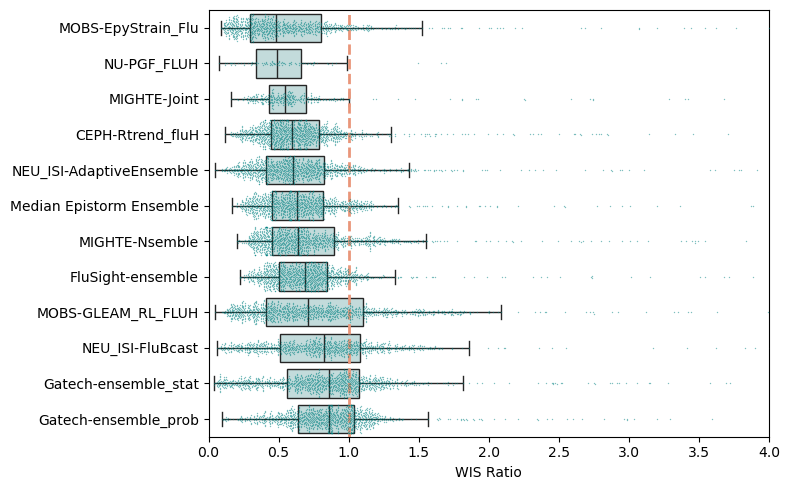

In [19]:
wisall['reference_date'] = wisall['target_end_date'] - pd.to_timedelta(wisall['horizon'] * 7, unit='days')
wis = wisall[wisall.reference_date>=pd.to_datetime('2025-09-01')]

wismean = wis.groupby('Model').wis_ratio.median().reset_index().sort_values(by='wis_ratio', ascending=True)
order = list(wismean.Model.unique())

fig,ax = plt.subplots(1,1,figsize=(8,5))
sns.boxplot(x='wis_ratio', y='Model', data=wis, orient='h', showfliers=False, color='teal', order=order)

for patch in ax.patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .25))
sns.swarmplot(x='wis_ratio', y='Model', data=wisall, color='teal', order=order, size=1, alpha=.5)


# plot vertical line
ax.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'darksalmon', alpha=1, linewidth=2)

plt.xlim([0,4])

plt.xlabel('WIS Ratio')
plt.ylabel('')

plt.tight_layout()
#plt.savefig("./figs/epistorm_ensemble/WISdist_2526.pdf")
plt.show()


# Taking average

In [49]:
wisall = pd.read_parquet('./wis_ratio_epistorm_models_2526.pq')
wisall['reference_date'] = wisall['target_end_date'] - pd.to_timedelta(wisall['horizon'] * 7, unit='days')
wis = wisall[wisall.reference_date>=pd.to_datetime('2025-09-01')]


wis_agg = wis.groupby(['location', 'Model']).wis_ratio.mean().reset_index()


In [21]:
wis_agg

,location,Model,wis_ratio
0,01,CEPH-Rtrend_fluH,0.638130
1,01,FluSight-ensemble,0.784760
2,01,Gatech-ensemble_prob,0.919123
3,01,Gatech-ensemble_stat,1.023405
4,01,MIGHTE-Joint,1.066657
...,...,...,...
570,US,MOBS-GLEAM_RL_FLUH,0.456760
571,US,Median Epistorm Ensemble,0.497389
572,US,NEU_ISI-AdaptiveEnsemble,0.575475
573,US,NEU_ISI-FluBcast,0.732789


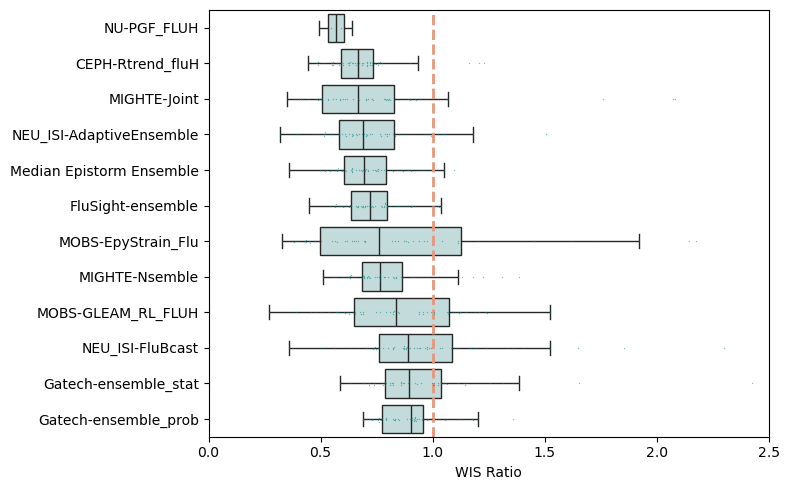

In [50]:
wismean = wis_agg.groupby('Model').wis_ratio.median().reset_index().sort_values(by='wis_ratio', ascending=True)
order = list(wismean.Model.unique())

fig,ax = plt.subplots(1,1,figsize=(8,5))
sns.boxplot(x='wis_ratio', y='Model', data=wis_agg, orient='h', showfliers=False, color='teal', order=order)

for patch in ax.patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .25))
sns.swarmplot(x='wis_ratio', y='Model', data=wis_agg, color='teal', order=order, size=1, alpha=.5)


# plot vertical line
ax.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'darksalmon', alpha=1, linewidth=2)

plt.xlim([0,2.5])

plt.xlabel('WIS Ratio')
plt.ylabel('')

plt.tight_layout()
#plt.savefig("./figs/epistorm_ensemble/WISdist_2526.pdf")
plt.show()


In [28]:
wismean

,Model,wis_ratio
11,NU-PGF_FLUH,0.569302
0,CEPH-Rtrend_fluH,0.665892
4,MIGHTE-Joint,0.668452
9,NEU_ISI-AdaptiveEnsemble,0.688474
8,Median Epistorm Ensemble,0.694254
1,FluSight-ensemble,0.717958
6,MOBS-EpyStrain_Flu,0.759108
5,MIGHTE-Nsemble,0.762813
7,MOBS-GLEAM_RL_FLUH,0.835809
10,NEU_ISI-FluBcast,0.891237


<Axes: >

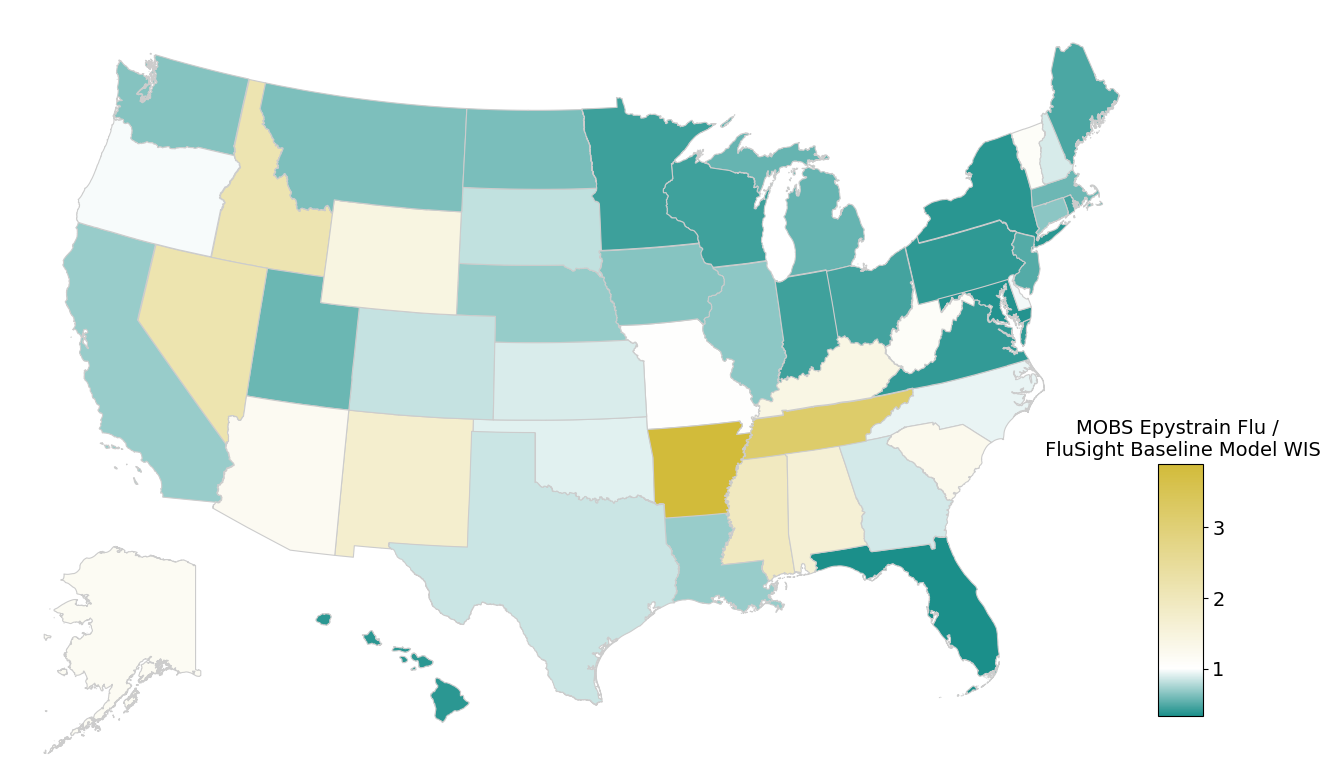

In [35]:
wisall = wis_agg[(wis_agg.Model=='MOBS-EpyStrain_Flu') & (wis_agg.location!='US')]
wisall['location'] = wisall['location'].astype(int)


us = gpd.read_file('./cb_2018_us_state_500k')
us = us.rename(columns={'STATEFP':'location'})
us['location'] = us['location'].astype(int)

# Merge datasets
merged = us.merge(wisall.groupby(by='location').median(), how='left', left_on='location', right_on='location')


variable = 'wis_ratio'

#colors = ['teal', 'white', 'sandybrown']
colors = ['#1b8f8a', 'white', '#d2bb3a']
# Create a colormap from the list of colors
cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', colors)

def makeColorColumn(gdf,variable,vmin,vmax):
    # apply a function to a column to create a new column of assigned colors & return full frame
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return gdf

gdf = merged.copy()

# make a column for value_determined_color in gdf
# set the range for the choropleth values with the upper bound the rounded up maximum value
vmin, vmax = gdf.wis_ratio.min(), gdf.wis_ratio.max() 

#vmin=.75
#vmax = 1.15
colormap = cmap
gdf = makeColorColumn(gdf,variable,vmin,vmax)
visframe = gdf.to_crs({'init':'epsg:2163'})


# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 12))
# remove the axis box around the vis
ax.axis('off')
#ax.set_xlim([-6,3])


# Create colorbar legend
fig = ax.get_figure()
# add colorbar axes to the figure
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.21])   

cbax.set_title('MOBS Epystrain Flu / \n FluSight Baseline Model WIS', fontdict={'fontsize': '14', 'fontweight' : '0'})

# add color scale

sm = plt.cm.ScalarMappable(cmap=colormap, \
                 norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax))


# reformat tick labels on legend
sm._A = []
cbar = fig.colorbar(sm, cax=cbax, spacing='proportional')
tick_font_size = 14
cbax.tick_params(labelsize=tick_font_size)
cbar.ax.set_yscale('linear')


# create map
for row in visframe.itertuples():
    if row.location not in [2, 15, 72, 69, 78, 60, 66]:
        vf = visframe[visframe.location==row.location]
        c = gdf[gdf.location==row.location][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')



# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.location==2]
alaska_gdf.clip(polygon).plot(color=gdf[gdf.location==2].value_determined_color, linewidth=0.8,ax=akax, edgecolor='0.8')


# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.2, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf.location==15]
hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='0.8')


#fig.savefig('./figs/epistorm_ensemble/WISratio_median_ensemble_map_2324.pdf', bbox_inches="tight")

# Geometric Mean

In [51]:
wisall = pd.read_parquet('./wis_ratio_epistorm_models_2526.pq')
wisall['reference_date'] = wisall['target_end_date'] - pd.to_timedelta(wisall['horizon'] * 7, unit='days')
wis = wisall[wisall.reference_date>=pd.to_datetime('2025-09-01')]


wis_agg = (wis.groupby(['location', 'Model'])['wis_ratio'].agg(gmean).reset_index())

In [40]:
wis_agg

,location,Model,wis_ratio
0,01,CEPH-Rtrend_fluH,0.596318
1,01,FluSight-ensemble,0.665692
2,01,Gatech-ensemble_prob,0.834842
3,01,Gatech-ensemble_stat,0.740081
4,01,MIGHTE-Joint,0.575968
...,...,...,...
570,US,MOBS-GLEAM_RL_FLUH,0.421372
571,US,Median Epistorm Ensemble,0.462562
572,US,NEU_ISI-AdaptiveEnsemble,0.558723
573,US,NEU_ISI-FluBcast,0.676823


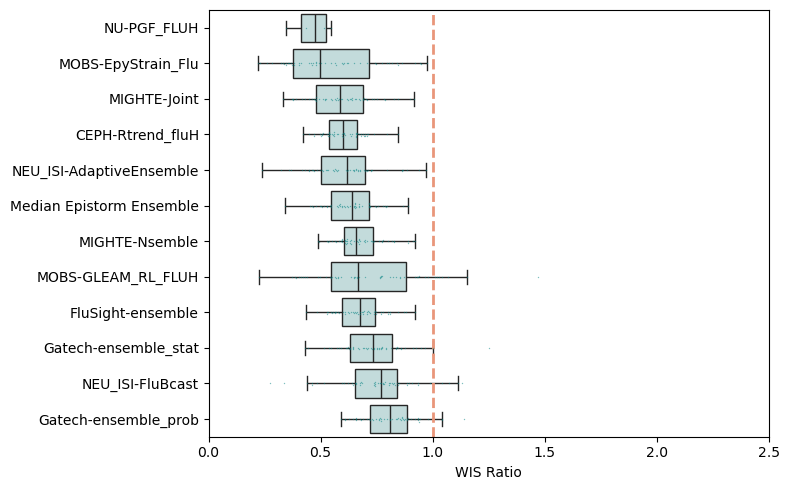

In [52]:
wismean = wis_agg.groupby('Model').wis_ratio.median().reset_index().sort_values(by='wis_ratio', ascending=True)
order = list(wismean.Model.unique())

fig,ax = plt.subplots(1,1,figsize=(8,5))
sns.boxplot(x='wis_ratio', y='Model', data=wis_agg, orient='h', showfliers=False, color='teal', order=order)

for patch in ax.patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .25))
sns.swarmplot(x='wis_ratio', y='Model', data=wis_agg, color='teal', order=order, size=1, alpha=.5)


# plot vertical line
ax.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'darksalmon', alpha=1, linewidth=2)

plt.xlim([0,2.5])

plt.xlabel('WIS Ratio')
plt.ylabel('')

plt.tight_layout()
#plt.savefig("./figs/epistorm_ensemble/WISdist_2526.pdf")
plt.show()


In [42]:
wismean

,Model,wis_ratio
11,NU-PGF_FLUH,0.476048
6,MOBS-EpyStrain_Flu,0.497605
4,MIGHTE-Joint,0.586361
0,CEPH-Rtrend_fluH,0.599377
9,NEU_ISI-AdaptiveEnsemble,0.617883
8,Median Epistorm Ensemble,0.639120
5,MIGHTE-Nsemble,0.655979
7,MOBS-GLEAM_RL_FLUH,0.666682
1,FluSight-ensemble,0.675973
3,Gatech-ensemble_stat,0.732602


<Axes: >

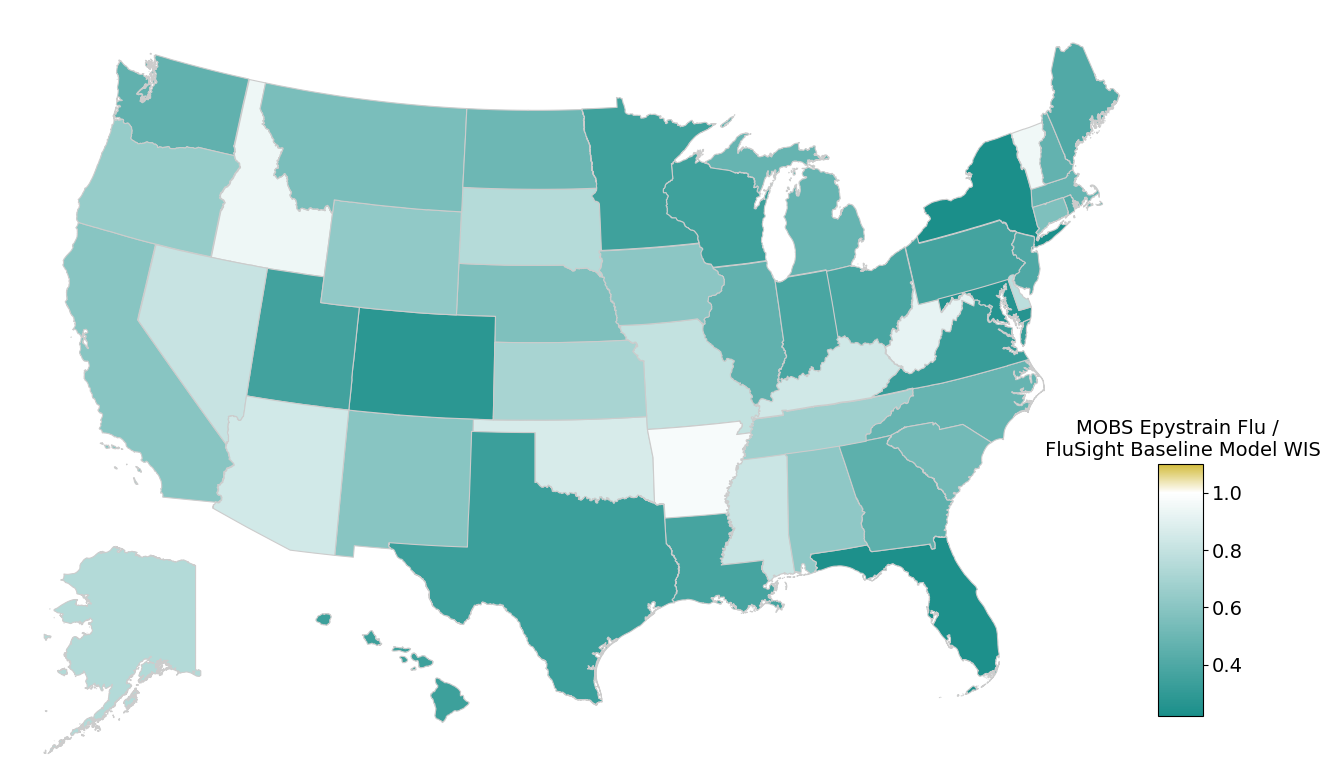

In [47]:
wisall = wis_agg[(wis_agg.Model=='MOBS-EpyStrain_Flu') & (wis_agg.location!='US')]
wisall['location'] = wisall['location'].astype(int)


us = gpd.read_file('./cb_2018_us_state_500k')
us = us.rename(columns={'STATEFP':'location'})
us['location'] = us['location'].astype(int)

# Merge datasets
merged = us.merge(wisall.groupby(by='location').median(), how='left', left_on='location', right_on='location')


variable = 'wis_ratio'

#colors = ['teal', 'white', 'sandybrown']
colors = ['#1b8f8a', 'white', '#d2bb3a']
# Create a colormap from the list of colors
cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', colors)

def makeColorColumn(gdf,variable,vmin,vmax):
    # apply a function to a column to create a new column of assigned colors & return full frame
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return gdf

gdf = merged.copy()

# make a column for value_determined_color in gdf
# set the range for the choropleth values with the upper bound the rounded up maximum value
vmin, vmax = gdf.wis_ratio.min(), gdf.wis_ratio.max() 

#vmin=.75
#vmax = 1.15
colormap = cmap
vmax=1.1
gdf = makeColorColumn(gdf,variable,vmin,vmax)
visframe = gdf.to_crs({'init':'epsg:2163'})


# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 12))
# remove the axis box around the vis
ax.axis('off')
#ax.set_xlim([-6,3])


# Create colorbar legend
fig = ax.get_figure()
# add colorbar axes to the figure
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.21])   

cbax.set_title('MOBS Epystrain Flu / \n FluSight Baseline Model WIS', fontdict={'fontsize': '14', 'fontweight' : '0'})

# add color scale

sm = plt.cm.ScalarMappable(cmap=colormap, \
                 norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax))


# reformat tick labels on legend
sm._A = []
cbar = fig.colorbar(sm, cax=cbax, spacing='proportional')
tick_font_size = 14
cbax.tick_params(labelsize=tick_font_size)
cbar.ax.set_yscale('linear')


# create map
for row in visframe.itertuples():
    if row.location not in [2, 15, 72, 69, 78, 60, 66]:
        vf = visframe[visframe.location==row.location]
        c = gdf[gdf.location==row.location][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')



# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.location==2]
alaska_gdf.clip(polygon).plot(color=gdf[gdf.location==2].value_determined_color, linewidth=0.8,ax=akax, edgecolor='0.8')


# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.2, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf.location==15]
hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='0.8')


#fig.savefig('./figs/epistorm_ensemble/WISratio_median_ensemble_map_2324.pdf', bbox_inches="tight")